In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_483058/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Magic Square"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2023-07-17"


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 316 non-null    object        
 1   author             316 non-null    object        
 2   date               316 non-null    datetime64[us]
 3   start              316 non-null    datetime64[us]
 4   end                316 non-null    datetime64[us]
 5   platform_proposal  316 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 14.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899961 entries, 0 to 899960
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        899961 non-null  object        
 1   proposal  899961 non-null  object        
 2   voter     899961 non-null  object        
 3   date      899961 non-null  datetime64[us]

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Magic Square/baseline/folds-info_7d_normalize.parquet
fold
2023-05-15      8749
2023-05-22     22639
2023-05-29     52766
2023-06-05    122736
2023-06-12    200990
2023-06-19    299068
2023-06-26    382096
2023-07-03    635264
2023-07-10    767025
2023-07-17    889321
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W20,13,8749,1518,673.00,5.76,983,259,75.62,3.80
2023-W21,32,22639,2668,707.47,8.49,4232,463,132.25,9.14
2023-W22,31,38219,3921,1232.87,9.75,6550,838,211.29,7.82
2023-W23,25,79300,9211,3172.00,8.61,8642,1118,345.68,7.73
2023-W24,23,101417,11452,4409.43,8.86,12919,2107,561.70,6.13
2023-W25,19,115239,13157,6065.21,8.76,23238,3310,1223.05,7.02
2023-W26,22,125302,12725,5695.55,9.85,22853,2983,1038.77,7.66
2023-W27,30,296582,25829,9886.07,11.48,31931,4620,1064.37,6.91
2023-W28,33,300109,27702,9094.21,10.83,59916,7712,1815.64,7.77


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W20 & 13 & 8749 & 1518 & 673.00 & 5.76 & 983 & 259 & 75.62 & 3.80 \\
2023-W21 & 32 & 22639 & 2668 & 707.47 & 8.49 & 4232 & 463 & 132.25 & 9.14 \\
2023-W22 & 31 & 38219 & 3921 & 1232.87 & 9.75 & 6550 & 838 & 211.29 & 7.82 \\
2023-W23 & 25 & 79300 & 9211 & 3172.00 & 8.61 & 8642 & 1118 & 345.68 & 7.73 \\
2023-W24 & 23 & 101417 & 11452 & 4409.43 & 8.86 & 12919 & 2107 & 561.70 & 6.13 \\
2023-W25 & 19 & 115239 & 13157 & 6065.21 & 8.76 & 23238 & 3310 & 1223.05 & 7.02 \\
2023-W26 & 22 & 125302 & 12725 & 5695.55 & 9.85 & 22853 & 2983 & 1038.77 & 7.66 \\
2023-W27 & 30 & 296582 & 25829 & 9886.07 & 11.48 & 31931 & 4620 & 1064.37 & 6.91 \\
2023-W28 

## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

    if ok_in_a_row > max_ok_in_a_row[0]:
        max_ok_in_a_row = (ok_in_a_row, t)

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row[0] == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/11 [00:00<?, ?it/s]

Warning, empty test fold 0 (2023-05-08 00:00:00), all ok since 0 folds ago


Max ok in a row: (11, Timestamp('2023-07-17 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Magic Square/baseline/openpop_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.486985,0.439767,0.391858,0.336837,0.298575,0.060901,0.486985,0.507568,0.517157,0.565267,...,0.590432,0.730709,0.909091,0.258185,0.449155,0.536662,0.616443,0.671314,0.700929,1.741740
std,0.298400,0.239672,0.203969,0.145586,0.127689,0.027132,0.298400,0.299405,0.300643,0.289179,...,0.291392,0.279428,0.301511,0.164048,0.227239,0.234987,0.256734,0.262408,0.264367,2.124888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073796
25%,0.322355,0.316430,0.283707,0.286864,0.232792,0.049634,0.322355,0.336605,0.337593,0.420013,...,0.474306,0.653159,1.000000,0.201461,0.357741,0.466399,0.561674,0.656273,0.669561,0.394405
50%,0.385518,0.395248,0.390065,0.364865,0.362677,0.070205,0.385518,0.430780,0.453456,0.513717,...,0.533650,0.806996,1.000000,0.237124,0.420624,0.538640,0.657049,0.740110,0.786692,0.681002
75%,0.712051,0.606270,0.508963,0.421735,0.393192,0.077495,0.712051,0.746246,0.773345,0.817657,...,0.805693,0.887199,1.000000,0.257264,0.512164,0.598811,0.716536,0.766190,0.806256,2.302780
max,0.964457,0.860173,0.742857,0.528401,0.422753,0.091404,0.964457,0.958439,0.949680,0.970180,...,0.977158,1.000000,1.000000,0.656635,0.872437,0.901742,0.944407,0.961210,0.963770,7.129106


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Magic Square/baseline/perfect_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.909091,0.770474,0.662416,0.491968,0.377201,0.060901,0.909091,0.909091,0.909091,0.909091,...,0.843224,0.888433,0.909091,0.322556,0.580821,0.704519,0.843224,0.888433,0.909091,2.067679
std,0.301511,0.270651,0.248013,0.202011,0.161728,0.027132,0.301511,0.301511,0.301511,0.301511,...,0.282708,0.295283,0.301511,0.161253,0.224360,0.250372,0.282708,0.295283,0.301511,2.429448
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.074538
25%,1.000000,0.800176,0.669520,0.441237,0.317700,0.049634,1.000000,1.000000,1.000000,1.000000,...,0.901352,0.962206,1.000000,0.259680,0.546957,0.700486,0.901352,0.962206,1.000000,0.561692
50%,1.000000,0.854800,0.736359,0.589095,0.458428,0.070205,1.000000,1.000000,1.000000,1.000000,...,0.929452,0.978702,1.000000,0.316806,0.578927,0.723655,0.929452,0.978702,1.000000,0.825589
75%,1.000000,0.901682,0.794096,0.614163,0.478047,0.077495,1.000000,1.000000,1.000000,1.000000,...,0.942778,0.992240,1.000000,0.356405,0.649640,0.819611,0.942778,0.992240,1.000000,2.964760
max,1.000000,0.944084,0.853233,0.672042,0.523254,0.091404,1.000000,1.000000,1.000000,1.000000,...,0.992512,1.000000,1.000000,0.663832,0.889992,0.933537,0.992512,1.000000,1.000000,8.129737


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,11,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,0.0,0.0
mean,2023-06-12 00:00:00,0.486985,0.439767,0.391858,0.336837,0.298575,0.060901,0.486985,0.507568,0.517157,...,0.909091,0.258185,0.449155,0.536662,0.616443,0.671314,0.700929,1.741740,NaN,NaN
min,2023-05-08 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073796,NaN,NaN
25%,2023-05-25 12:00:00,0.322355,0.316430,0.283707,0.286864,0.232792,0.049634,0.322355,0.336605,0.337593,...,1.000000,0.201461,0.357741,0.466399,0.561674,0.656273,0.669561,0.394405,NaN,NaN
50%,2023-06-12 00:00:00,0.385518,0.395248,0.390065,0.364865,0.362677,0.070205,0.385518,0.430780,0.453456,...,1.000000,0.237124,0.420624,0.538640,0.657049,0.740110,0.786692,0.681002,NaN,NaN
75%,2023-06-29 12:00:00,0.712051,0.606270,0.508963,0.421735,0.393192,0.077495,0.712051,0.746246,0.773345,...,1.000000,0.257264,0.512164,0.598811,0.716536,0.766190,0.806256,2.302780,NaN,NaN
max,2023-07-17 00:00:00,0.964457,0.860173,0.742857,0.528401,0.422753,0.091404,0.964457,0.958439,0.949680,...,1.000000,0.656635,0.872437,0.901742,0.944407,0.961210,0.963770,7.129106,NaN,NaN
std,NaN,0.298400,0.239672,0.203969,0.145586,0.127689,0.027132,0.298400,0.299405,0.300643,...,0.301511,0.164048,0.227239,0.234987,0.256734,0.262408,0.264367,2.124888,NaN,NaN


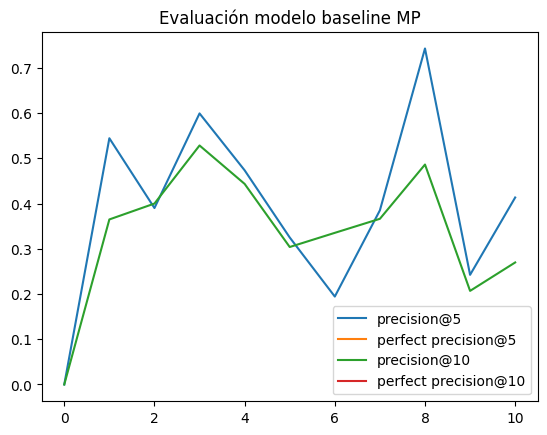

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-06-15 12:00:00,0.535684,0.483744,0.431044,0.370521,0.328433,0.066991,0.535684,0.558325,0.568873,...,1.0,0.284003,0.494071,0.590328,0.678087,0.738446,0.771022,1.908535,NaN,NaN
min,2023-05-15 00:00:00,0.204834,0.203827,0.194381,0.206924,0.197995,0.030150,0.204834,0.215350,0.221142,...,1.0,0.146305,0.345611,0.420764,0.411503,0.441560,0.505781,0.187275,NaN,NaN
25%,2023-05-30 18:00:00,0.370555,0.354873,0.340038,0.311769,0.259045,0.063265,0.370555,0.384914,0.397553,...,1.0,0.220912,0.376029,0.506657,0.570910,0.679210,0.705084,0.475432,NaN,NaN
50%,2023-06-15 12:00:00,0.423528,0.435996,0.401731,0.365587,0.363524,0.073408,0.423528,0.475189,0.497823,...,1.0,0.238601,0.422794,0.543682,0.676349,0.749397,0.793425,1.000520,NaN,NaN
75%,2023-07-01 06:00:00,0.736334,0.608425,0.526682,0.432603,0.398540,0.077594,0.736334,0.773630,0.797801,...,1.0,0.257942,0.549158,0.619027,0.719138,0.768130,0.806874,2.357377,NaN,NaN
max,2023-07-17 00:00:00,0.964457,0.860173,0.742857,0.528401,0.422753,0.091404,0.964457,0.958439,0.949680,...,1.0,0.656635,0.872437,0.901742,0.944407,0.961210,0.963770,7.129106,NaN,NaN
std,NaN,0.264482,0.200469,0.165706,0.098403,0.084972,0.019095,0.264482,0.260990,0.260271,...,0.0,0.147494,0.180880,0.161721,0.163680,0.146382,0.132694,2.162593,NaN,NaN
